In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [96]:
# load your dataset
data_dir = os.path.join(os.getcwd(), 'data_files')

target_df = pd.read_csv(os.path.join(data_dir, 'targets.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df = pd.read_csv(os.path.join(data_dir, 'predictors.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df['Holiday'] = predictor_df['Holiday'].astype(int)

df = target_df.join(predictor_df).sort_index(ascending=True)
df.dropna(inplace=True)

C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pred

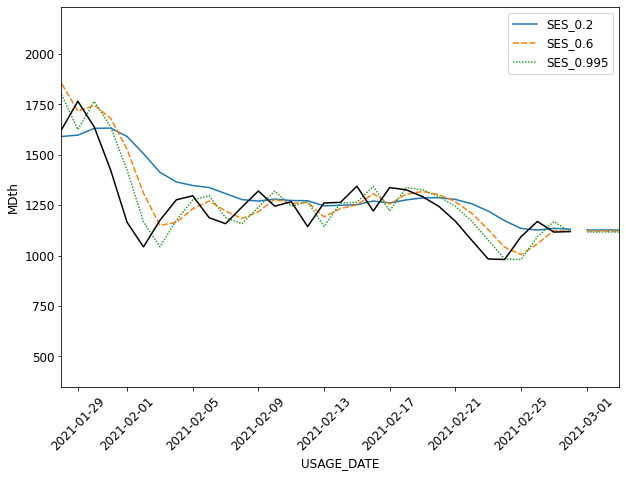

In [97]:
# Simple exponential smoothing
forecast_days = 3
forecast_dates = pd.date_range(start = df.index.max(), end = df.index.max()+pd.DateOffset(days=forecast_days))[1:]

# exponential smoothing requires sorting dates with latest at the bottom!!!!
fit1 = ExponentialSmoothing(df['SoCal_TOTAL'], initialization_method="heuristic").fit(smoothing_level=0.2,optimized=False)
fit2 = ExponentialSmoothing(df['SoCal_TOTAL'], initialization_method="heuristic").fit(smoothing_level=0.6,optimized=False)
fit3 = ExponentialSmoothing(df['SoCal_TOTAL'], initialization_method="estimated").fit()

fit_df = pd.DataFrame({'SES_0.2':fit1.fittedvalues, 
                       'SES_0.6': fit2.fittedvalues, 
                       'SES_' +str(fit3.model.params['smoothing_level']): fit3.fittedvalues})

forecast_df = pd.DataFrame({'USAGE_DATE': forecast_dates, 
                            'SES_0.2':fit1.forecast(forecast_days),
                            'SES_0.6': fit2.forecast(forecast_days), 
                            'SES_' +str(fit3.model.params['smoothing_level']): fit3.forecast(forecast_days)}).set_index('USAGE_DATE')

plt.figure(figsize=(10, 7))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=fit_df, legend=True)
sns.lineplot(data=df, x=df.index, y='SoCal_TOTAL', color='k', legend=True)
sns.lineplot(data=forecast_df, legend=False)
plt.xticks(rotation=45), plt.xlim([fit_df.index.max() - pd.DateOffset(months=1), forecast_df.index.max()])
plt.ylabel('MDth')
plt.show()

C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Pred

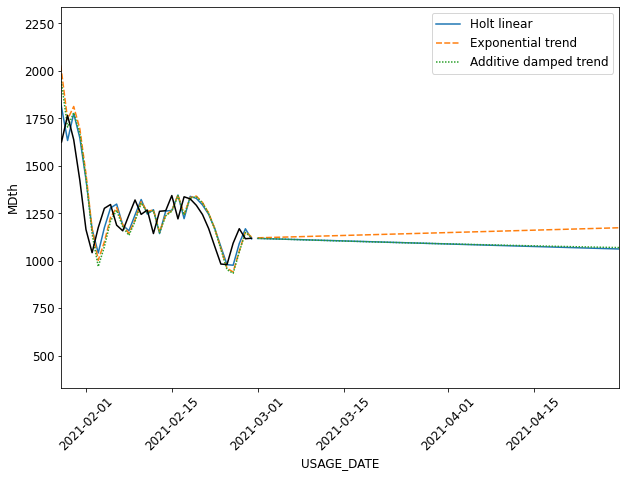

In [108]:
forecast_days = 60
forecast_dates = pd.date_range(start = df.index.max(), end = df.index.max()+pd.DateOffset(days=forecast_days))[1:]


holt1 = Holt(df['SoCal_TOTAL'], initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)
holt2 = Holt(df['SoCal_TOTAL'], exponential=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)
holt3 = Holt(df['SoCal_TOTAL'], damped_trend=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2)

holt_df = pd.DataFrame({'Holt linear': holt1.fittedvalues, 
                       'Exponential trend': holt2.fittedvalues, 
                       'Additive damped trend' : holt3.fittedvalues})

holt_fcst_df = pd.DataFrame({'USAGE_DATE': forecast_dates, 
                             'Holt linear' :holt1.forecast(forecast_days),
                             'Exponential trend': holt2.forecast(forecast_days), 
                             'Additive damped trend': holt3.forecast(forecast_days)}).set_index('USAGE_DATE')

plt.figure(figsize=(10, 7))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=holt_df, legend=True)
sns.lineplot(data=df, x=df.index, y='SoCal_TOTAL', color='k', legend=True)
sns.lineplot(data=holt_fcst_df, legend=False)
plt.xticks(rotation=45), plt.xlim([holt_df.index.max() - pd.DateOffset(months=1), holt_fcst_df.index.max()])
plt.ylabel('MDth')
plt.show()

In [111]:
holt2.params

{'smoothing_level': 0.8,
 'smoothing_trend': 0.2,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 1706.8114045466655,
 'initial_trend': 0.9709597201829131,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}